In [15]:
#pip install kagglehub

In [16]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
datamunge_sign_language_mnist_path = kagglehub.dataset_download('datamunge/sign-language-mnist')

print('Data source import complete.')

Data source import complete.


In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):                                        # SOLO PARA KAGGLE
for dirname, _, filenames in os.walk(datamunge_sign_language_mnist_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\american_sign_language.PNG
C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\amer_sign2.png
C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\amer_sign3.png
C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\sign_mnist_test.csv
C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\sign_mnist_train.csv
C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\sign_mnist_test\sign_mnist_test.csv
C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\sign_mnist_train\sign_mnist_train.csv


Cargo los datos y los separo en desarrollo y evaluación final

In [18]:
data_eval = pd.read_csv(r'C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\sign_mnist_test\sign_mnist_test.csv')
data_dev = pd.read_csv(r'C:\Users\aaron\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1\sign_mnist_train\sign_mnist_train.csv').sample(frac=1, random_state=28)
X_eval, y_eval = data_eval.iloc[:, 1:], data_eval.iloc[:, 0]
X_dev, y_dev = data_dev.iloc[:, 1:], data_dev.iloc[:, 0]
X_dev.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
13555,189,193,196,201,205,209,211,212,213,214,...,81,70,66,64,64,59,53,55,62,48
3670,111,118,125,129,136,141,143,144,148,151,...,8,142,229,219,220,221,221,221,221,221
1347,169,172,175,178,180,183,184,185,187,189,...,218,217,216,215,213,212,211,210,208,207


In [19]:
y_dev.head(3)

13555     7
3670     16
1347      7
Name: label, dtype: int64

## Exploracion

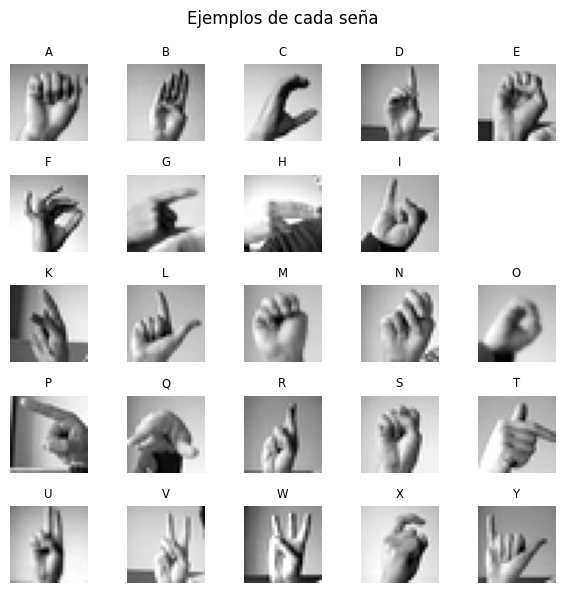

In [20]:
# funcion auxiliar
def graficar_fila(row, ax, label=None):
    n = int(np.sqrt(len(row)))
    ax.imshow(row.values.reshape(n, n), cmap='gray')
    if label is not None:
        ax.set_title(label, fontsize='small')
    ax.axis('off')

leters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    X_dev_i = X_dev[y_dev == i]
    if X_dev_i.shape[0] > 0:
        graficar_fila(X_dev_i.iloc[0], ax=ax, label=leters[i])
    else:
        ax.axis('off')
fig.suptitle('Ejemplos de cada seña')
fig.tight_layout()

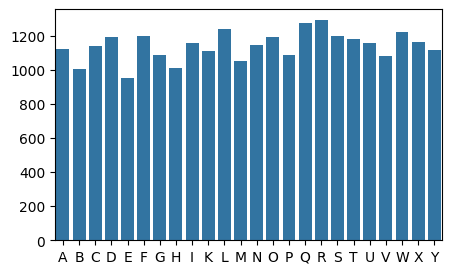

In [21]:
# proporcion de cada letra en el dataset de desarrollo
count = y_dev.value_counts().sort_index()
plt.figure(figsize=(5, 3))
sns.barplot(x=[leters.get(i, '?') for i in count.index], y=count.values)
plt.show()

Los datos estan balanceados, no hay necesidad de hacer stratified sampling.

In [22]:
if X_dev.shape[0] == X_dev.value_counts().shape[0]: # no hay duplicados en el dataset de desarrollo
    print('No hay duplicados en el dataset de desarrollo')
else:
    print('Hay duplicados en el dataset de desarrollo, limpiar el dataset para evitar filtacion de datos')

No hay duplicados en el dataset de desarrollo


## Un modelo simple
Arbol de profundidad maxima 10

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_dev_train, X_dev_test, y_dev_train, y_dev_test = train_test_split(X_dev, y_dev, test_size=0.3, random_state=28)
tree = DecisionTreeClassifier(max_depth=10, random_state=28)
tree.fit(X_dev_train, y_dev_train)
y_dev_pred = tree.predict(X_dev_test)

print('Accuracy con test: ', accuracy_score(y_dev_test, y_dev_pred))

Accuracy con test:  0.5805511715430375


Veamos donde caen las features (pixeles) mas importantes para este modelo, ello veamos como se distribuyen. Esto nos dara un cota inferior razonable.

Text(0.5, 1.0, 'Importancia de los pixels')

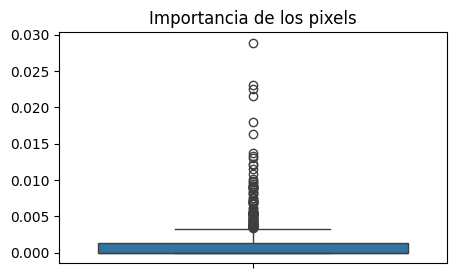

In [24]:
plt.figure(figsize=(5, 3))
sns.boxplot(tree.feature_importances_)
plt.title('Importancia de los pixels')

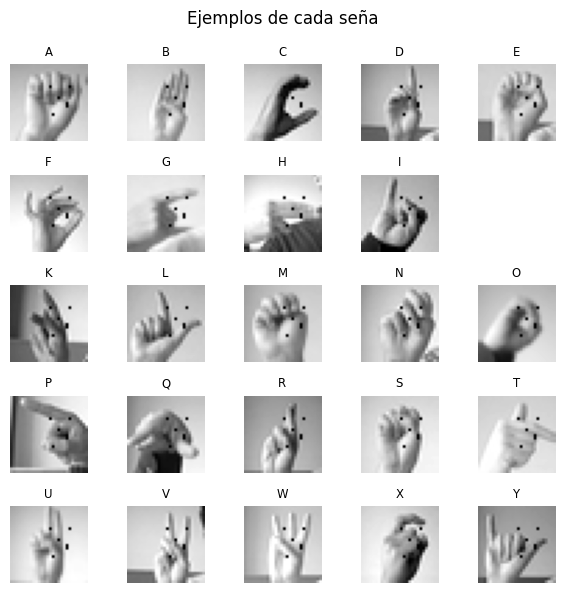

In [25]:
pixeles_mas_importantes = X_dev.columns[tree.feature_importances_ > 0.015] # cota elegida a ojo

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    X_dev_i = X_dev[y_dev == i]
    if X_dev_i.shape[0] > 0:
        row = X_dev_i.iloc[0]
        row[pixeles_mas_importantes] = 0 # en negro
        graficar_fila(row, ax=ax, label=leters[i])
    else:
        ax.axis('off')
fig.suptitle('Ejemplos de cada seña')
fig.tight_layout()

Se observa que la mayoría de ellos se ubican sobre los dedos y contornos de la mano, lo que indica que el modelo está aprendiendo patrones coherentes con las diferencias morfológicas entre las clases. En algunos casos, como en las letras "C" o "L", los píxeles relevantes están claramente alineados con la forma característica del gesto, lo que refuerza la interpretación de que el modelo está focalizando en información útil.

### Validacion cruzada con 5 folds

In [26]:
scoring = {
    'accuracy': 'accuracy',
    'auprc': 'average_precision',
    'roc_auc': 'roc_auc_ovr'
}

scores = cross_validate(DecisionTreeClassifier(max_depth=10), X_dev_test, y_dev_test, cv=5, scoring=scoring, n_jobs=-1)

print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_auprc', 'test_roc_auc'])


In [27]:
# Calculating mean scores for each metric
accuracy_scores = scores['test_accuracy']
auprc_scores = scores['test_auprc']
roc_auc_scores = scores['test_roc_auc']

mean_accuracy = np.mean(accuracy_scores)
mean_auprc = np.mean(auprc_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Creating a DataFrame for scores
scores_df = pd.DataFrame({
    'Fold': range(1, len(accuracy_scores) + 1),
    'Accuracy': accuracy_scores,
    'AUPRC': auprc_scores,
    'ROC AUC OneVSRest': roc_auc_scores
})

# Adding the mean row
mean_row = pd.DataFrame({
    'Fold': ['Mean'],
    'Accuracy': [mean_accuracy],
    'AUPRC': [mean_auprc],
    'ROC AUC OneVSRest': [mean_roc_auc]
})
scores_df = pd.concat([scores_df, mean_row], ignore_index=True)

# Displaying the table
print(scores_df)

   Fold  Accuracy     AUPRC  ROC AUC OneVSRest
0     1  0.531553  0.517467           0.880927
1     2  0.519417  0.475869           0.871022
2     3  0.526412  0.503313           0.881324
3     4  0.514876  0.483798           0.875735
4     5  0.517304  0.486299           0.875594
5  Mean  0.521912  0.493349           0.876920


Los resultados muestran que el modelo tiene un desempeño bastante flojo: la accuracy ronda el 50% y el AUPRC también es bajo. Aunque el ROC AUC por clase está un poco mejor (~0.85). En general, parece que el modelo no distingue bien entre las clases.

## Comparacion de algoritmos

Realizamoso RandomizedSearchCV con Arboles de decision, KNN y SVM. Usamos como metrica de performance accuracy ya que tenemo un dataset balanceado (por lo menos los de desarrollo). 

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

tree_param_grid = {
    'max_depth': range(1,100), 'criterion': ['gini', 'entropy'],
    'random_state':[28]
}

knn_param_grid = {
    'algorithm' :['ball_tree'],
    'n_neighbors': range(1,50)
}

#svm_param_grid = {
#    'C': np.linspace(0.01,20, 15),
#    'random_state':[28]
#}

rscv_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_param_grid, n_iter=8, cv=4, scoring='accuracy', n_jobs=-1, random_state=28)
rscv_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_param_grid, n_iter=8, cv=4, scoring='accuracy', n_jobs=-1, random_state=28)
#rscv_svm = RandomizedSearchCV(SVC(), svm_param_grid, n_iter=3, cv=3, scoring='accuracy', n_jobs=-1, random_state=28)

rscv_tree.fit(X_dev_train, y_dev_train)
print('Mejores hiperparametros para arbol de decision: ', rscv_tree.best_params_)
print('         Accuracy: ', rscv_tree.best_score_)
print()
rscv_knn.fit(X_dev_train, y_dev_train)
print('Mejores hiperparametros para KNN: ', rscv_knn.best_params_)
print('         Accuracy: ', rscv_knn.best_score_)
print()
#rscv_svm.fit(X_dev_train, y_dev_train)
#print('Mejores hiperparametros para SVM: ', rscv_svm.best_params_)
#print('         Accuracy: ', rscv_svm.best_score_)


Mejores hiperparametros para arbol de decision:  {'random_state': 28, 'max_depth': 71, 'criterion': 'entropy'}
         Accuracy:  0.8611717732621358

Mejores hiperparametros para KNN:  {'n_neighbors': 10, 'algorithm': 'ball_tree'}
         Accuracy:  0.9728902098580701



Veamos que tal LDA y Naive Bayes

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes

scores_LDA = cross_val_score(LinearDiscriminantAnalysis(), X_dev_train, y_dev_train, cv=4, scoring='accuracy')
print('Cross validation scores for LDA:', scores_LDA)
print('         Mean:', scores_LDA.mean())
print()

for func in [naive_bayes.GaussianNB, naive_bayes.MultinomialNB]:
    scores = cross_val_score(func(), X_dev_train, y_dev_train, cv=4, scoring='accuracy')
    print(f'Cross validation scores for {func.__name__}:', scores)
    print('            Mean:', scores.mean())
    print()

scores_RF = cross_val_score(RandomForestClassifier(), X_dev_train, y_dev_train, cv=4, scoring='accuracy')
print('Cross validation scores for RandomForest:', scores_RF)
print('         Mean:', scores_RF.mean())
print()


Cross validation scores for LDA: [0.98668054 0.98189386 0.98563697 0.98834305]
         Mean: 0.9856386045794304

Cross validation scores for GaussianNB: [0.43808533 0.46347555 0.45024979 0.46003331]
            Mean: 0.4529609928770769

Cross validation scores for MultinomialNB: [0.52715921 0.54484912 0.52268943 0.53830142]
            Mean: 0.5332497914069181

Cross validation scores for LDA: [0.99354839 0.99146722 0.99146545 0.99417152]
         Mean: 0.9926631444833086



## Sesgo y varianza

Estudiaremos mas a fondo el mejor arbol, Random Forest, SVM y Linear discriminant analysis (LDA)

### Curvas de complejidad

In [30]:
def curva(model, X_train, X_test, y_train, y_test, param :str, max_complex: int, step):
    sub_train_error = []
    test_error = []
    for i in np.arange(1, max_complex, step):
        model2 = model(**{param: int(i)})
        model2.fit(X_train, y_train)
        sub_train_error.append(1 - accuracy_score(y_train, model2.predict(X_train)))
        test_error.append(1 - accuracy_score(y_test, model2.predict(X_test)))
    return sub_train_error, test_error

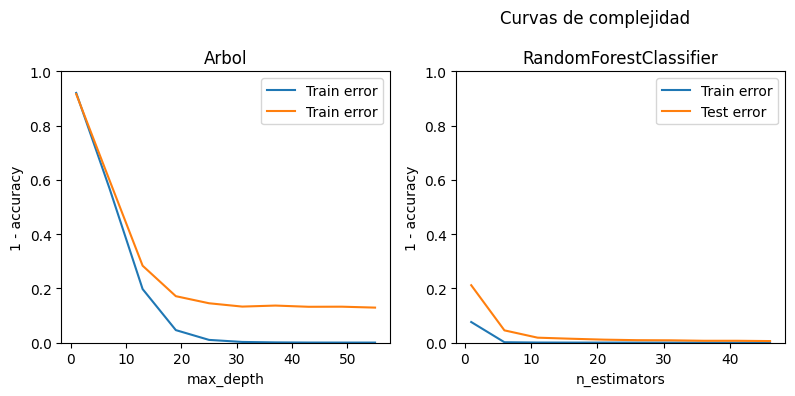

In [ ]:
plt.figure(figsize=(12, 4))

max_complex = 60
x = np.arange(1, max_complex, max_complex//10)
y_1, y_2 = curva(DecisionTreeClassifier, X_dev_train, X_dev_test, y_dev_train, y_dev_test, 'max_depth', max_complex, max_complex//10)

plt.subplot(1,2,1)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Train error")
plt.title("Arbol")
plt.xlabel("max_depth")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

max_complex = 50
y_1, y_2 = curva(RandomForestClassifier, X_dev_train, X_dev_test, y_dev_train, y_dev_test, 'n_estimators', max_complex, max_complex//10)
x = np.arange(1, max_complex, max_complex//10)

plt.subplot(1,2,2)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

#max_complex = 50
#y_1, y_2 = curva(SVC, X_dev_train, X_dev_test, y_dev_train, y_dev_test, 'C', max_complex, max_complex//10)
#x = np.arange(1, max_complex, max_complex//10)
#
#plt.subplot(1,3,3)
#plt.plot(x, y_1, label="Train error")
#plt.plot(x, y_2, label="Test error")
#plt.title("SVM")
#plt.xlabel("C")
#plt.ylabel("1 - accuracy")
#plt.ylim((0,1))
#plt.legend()

plt.suptitle('Curvas de complejidad')
plt.tight_layout()
plt.show()

### Curvas de aprendizaje

In [32]:
from copy import deepcopy
def curva_de_aprendizaje(model, X_train, X_test, y_train, y_test):
    sub_train_error = []
    test_error = []
    for i in np.linspace(800, len(X_dev_train), 15):
        i = int(i)
        X_train_i = X_train.iloc[:i,:]
        y_train_i = y_train.iloc[:i]
        X_test_i  =  X_test.iloc[:i,:]
        y_test_i  =  y_test.iloc[:i]
        model2 = deepcopy(model)
        model2.fit(X_train_i, y_train_i)
        sub_train_error.append(1 - accuracy_score(y_train_i, model2.predict(X_train_i)))
        test_error.append(1 - accuracy_score(y_test_i, model2.predict(X_test_i)))
    return sub_train_error, test_error

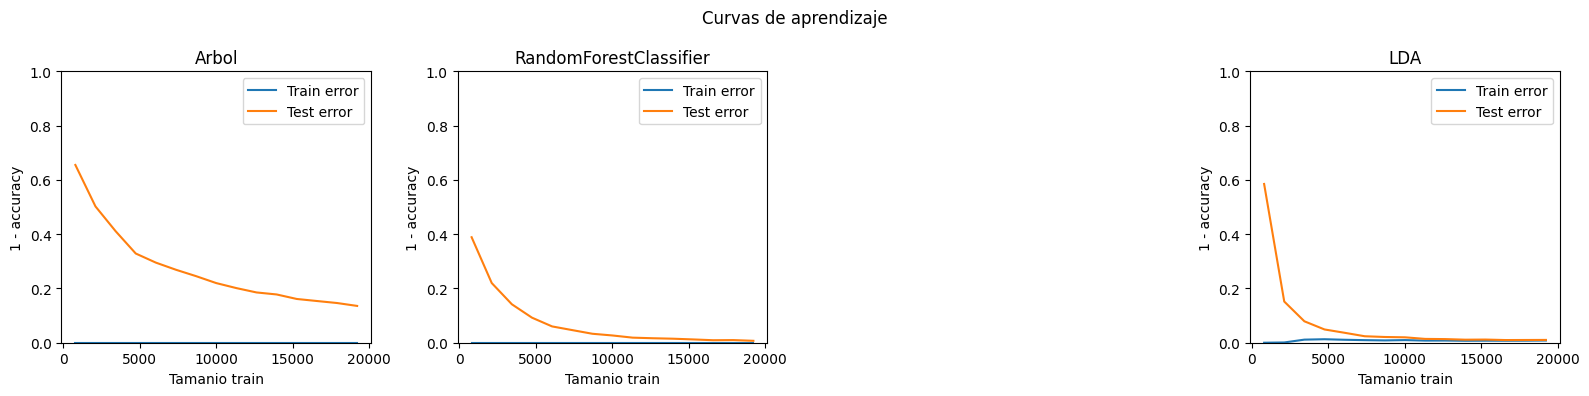

In [ ]:
x = np.linspace(800, len(X_dev_train), 15)
plt.figure(figsize=(16, 4))

y_1, y_2 = curva_de_aprendizaje(DecisionTreeClassifier(max_depth=80), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,3,1)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("Arbol")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

y_1, y_2 = curva_de_aprendizaje(RandomForestClassifier(n_estimators=30), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,3,2)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("RandomForestClassifier")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

#y_1, y_2 = curva_de_aprendizaje(SVC(C=20), X_dev_train, X_dev_test, y_dev_train, y_dev_test)
#
#plt.subplot(1,4,4)
#plt.plot(x, y_1, label="Train error")
#plt.plot(x, y_2, label="Test error")
#plt.title("SVM")
#plt.xlabel("Tamanio train")
#plt.ylabel("1 - accuracy")
#plt.ylim((0,1))
#plt.legend()

y_1, y_2 = curva_de_aprendizaje(LinearDiscriminantAnalysis(), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,3,3)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("LDA")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

plt.suptitle('Curvas de aprendizaje')
plt.tight_layout()
plt.show()

## Evaluacion de performance